In [91]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [92]:
#export 
from exp.tests import MNIST_URL, test, test_eq, test_near
from fastai import datasets
import pickle, gzip
from torch import tensor

def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_tr, y_tr), (x_vl, y_vl), _) = pickle.load(f, encoding='latin-1')
        return map(tensor, (x_tr, y_tr, x_vl, y_vl))

In [53]:
import matplotlib.pyplot as plt
import torch
import matplotlib as mpl

In [20]:
x_tr, y_tr, x_vl, y_vl = get_data()

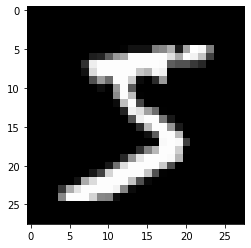

In [21]:
x = x_tr[0]
mpl.rcParams['image.cmap'] = 'gray'
plt.imshow(x.view(28,28))

In [23]:
tr_mean, tr_std = x_tr.mean(), x_tr.std()
vl_mean, vl_std = x_vl.mean(), x_vl.std()
tr_mean, tr_std, vl_mean, vl_std

(tensor(0.1304), tensor(0.3073), tensor(0.1287), tensor(0.3050))

In [30]:
#export
def normalize(x, m=None, s=None):
    assert (m is None and s is None) or (m is not None and s is not None)
    if m is None:
        m = x.mean()
        s = x.std()
    return (x - m) / s
def get_stats(x):
    return x.mean(), x.std()

In [32]:
get_stats(normalize(x))

(tensor(3.6265e-08), tensor(1.0000))

In [33]:
#export
def test_near_zero(a, tol=1e-3): assert a.abs()<tol,f"Near zero: {a}"

In [41]:
test_near_zero(tensor([0.0001]))

In [44]:
assert y_tr.max() == 9
assert y_tr.min() == 0

In [45]:
# NOTE: try with higher standard deviations later
# may help to get more precision
# since distance between two points in weights space can be shown with higher precision

In [49]:
nh = 50
n, m = x_tr.shape
c = y_tr.max() + 1
n, m, c

(50000, 784, tensor(10))

In [169]:
#export 
import math
def init_weights(i,o,isForward=True):
    # xavier
    return torch.randn(i,o)*math.sqrt(2/(i if isForward else o))

In [170]:
w1 = init_weights(m, nh)
b1 = torch.zeros(nh)
w2 = init_weights(nh, 1)
b2 = torch.zeros(1)
w1.shape, b1.shape, w2.shape, b2.shape

(torch.Size([784, 50]), torch.Size([50]), torch.Size([50, 1]), torch.Size([1]))

In [171]:
get_stats(w1), get_stats(w2)

((tensor(6.4545e-05), tensor(0.0505)), (tensor(0.0053), tensor(0.2077)))

In [172]:
w1.std(), tensor(1/math.sqrt(m))

(tensor(0.0505), tensor(0.0357))

In [173]:
w1.std() - 1/math.sqrt(2/m)

tensor(-19.7485)

In [174]:
# test_near_zero(w1.std() - 1/math.sqrt(2/m))

In [175]:
x_trm, x_trs = get_stats(x_tr)
x_tr = normalize(x_tr, x_trm, x_trs)
x_vl = normalize(x_vl, x_trm, x_trs)
x_tr.mean(), x_tr.std(), x_vl.mean(), x_vl.std()

(tensor(-2.5989e-07), tensor(1.), tensor(-0.0058), tensor(0.9924))

In [184]:
def lin(x, w, b): return x@w + b

In [185]:
%time t = lin(x_tr, w1, b1)
t.mean(), t.std()

CPU times: user 118 ms, sys: 0 ns, total: 118 ms
Wall time: 58.8 ms


(tensor(-0.0230), tensor(1.4503))

In [194]:
def relu(x): return x.clamp_min(0.) - 0.5

In [195]:
%time t1 = relu(lin(x_tr, w1, b1))
t1.mean(), t1.std()

CPU times: user 72.8 ms, sys: 55 µs, total: 72.9 ms
Wall time: 36.2 ms


(tensor(0.0620), tensor(0.8502))

In [196]:
def model(xb):
    l1 = lin(xb, w1, b1)
    l2 = relu(l1)
    l3 = lin(l2, w2, b2)
    return l3

In [200]:
%timeit -n 10 _ = model(x_tr)

37.2 ms ± 956 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [202]:
y_tr_hat = model(x_tr)
y_tr_hat.shape

torch.Size([50000, 1])

In [207]:
y_tr.shape

torch.Size([50000])

In [204]:
#export 
def mse(output, target):
    return (output.squeeze(-1) - target).pow(2).mean()

In [205]:
mse(y_tr_hat, y_tr)

tensor(21.1896)

mse : (summation (y - yhat)^2) / number of elements
diff: summ 2*(y-yhat) / n = 2(y-yhat).mean

In [211]:
def mse_grad(inp, out):
    inp.g = 2 * (inp.squeeze(1) - out)[...,None] / out.shape[0]

In [219]:
mse_grad(y_tr_hat, y_tr)#, mse_grad1(y_tr_hat, y_tr)
y_tr_hat.g.shape

torch.Size([50000, 1])

In [220]:
def relu_grad(inp, out):
    inp.g = (inp > 0).float() * out.g

 linear: y = x @ w + b
 dy/dx = wT
 
 mse( relu (lin(x)))
 
 x -> lin -> x1 -> relu -> x2 -> mseloss
 
mseloss = (y-x2)^2 / n
dmseloss/dx2 = 2(y-x2) / n
dmseloss/dx1 = 2(y-x2)/n * dx2/dx1

dmseloss/dx = dmseloss/dx1 * dx1/dx
x1 = x@w + b

look for explanation here.
or in jeremys linear algebra paper
http://cs231n.stanford.edu/handouts/linear-backprop.pdf
dx1/dx = w.T
dmseloss/dx = dmessloss/dx1 @ w.T 

In [ ]:
def lin_grad(inp, out, w, b):
    inp.g = out.g @ w.t
    w.g = out.g * x